<a href="https://colab.research.google.com/github/Amjadkp/Deep_Learning_Lab/blob/main/PPCA_and_ICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Question 1: PPCA for Image Compression (using PCA for comparison)**

Loading MNIST data...
Original shape: (2000, 784)
Compressed shape: (2000, 50) (represents the data in the latent space)
Reconstructed shape: (2000, 784)
Mean Squared Error (MSE): 0.0110


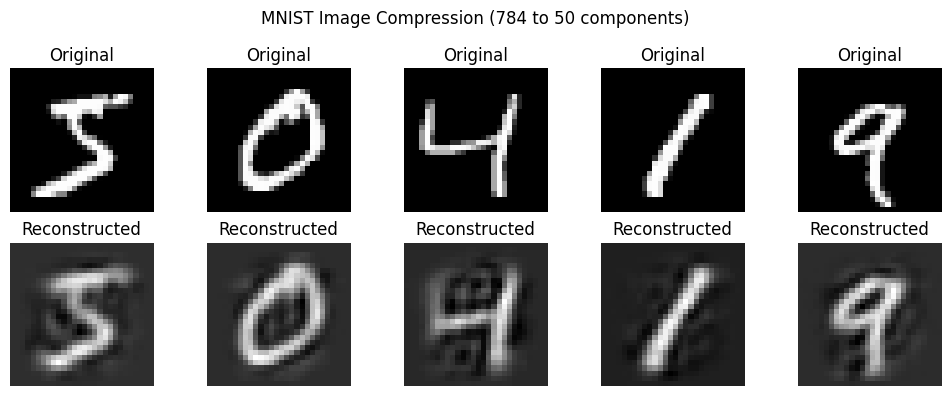

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error

# 1. Load and Prepare Data
print("Loading MNIST data...")
# Load the MNIST dataset (images of 28x28 pixels)
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X = mnist.data / 255.0  # Normalize pixel values to [0, 1]
# Use a subset of the data for faster execution in a notebook
X_subset = X[:2000]

n_components = 50  # Dimensionality reduction target (e.g., from 784 to 50)

# 2. Apply PCA
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X_subset)

# 3. Reconstruction
X_reconstructed = pca.inverse_transform(X_reduced)

# 4. Comparison (Visualization and Error)
print(f"Original shape: {X_subset.shape}")
print(f"Compressed shape: {X_reduced.shape} (represents the data in the latent space)")
print(f"Reconstructed shape: {X_reconstructed.shape}")

# Calculate Reconstruction Error (MSE)
mse = mean_squared_error(X_subset, X_reconstructed)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Plot original vs. reconstructed images
n_images_to_plot = 5
fig, axes = plt.subplots(2, n_images_to_plot, figsize=(10, 4))
fig.suptitle(f'MNIST Image Compression (784 to {n_components} components)')

for i in range(n_images_to_plot):
    # Original Image
    ax = axes[0, i]
    ax.imshow(X_subset[i].reshape(28, 28), cmap='gray')
    ax.set_title('Original')
    ax.axis('off')

    # Reconstructed Image
    ax = axes[1, i]
    ax.imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
    ax.set_title('Reconstructed')
    ax.axis('off')

plt.tight_layout()
plt.show()

**Question 2: PPCA with Missing Data**

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error

# 1. Create a synthetic dataset and introduce missing values
np.random.seed(42)
n_samples, n_features = 100, 10
latent_dim = 3 # The true underlying dimensionality

# Generate a synthetic dataset with low-rank structure
W_true = np.random.randn(n_features, latent_dim)
Z_true = np.random.randn(n_samples, latent_dim)
# True data X_true = Z_true @ W_true.T + noise
X_true = Z_true @ W_true.T + 0.5 * np.random.randn(n_samples, n_features)

# Create the dataset with missing values
X_missing = X_true.copy()
missing_mask = np.random.choice([True, False], size=X_true.shape,
                                p=[0.10, 0.90]) # 10% missing values
X_missing[missing_mask] = np.nan

# Store the true values that are now missing for error comparison
true_missing_values = X_true[missing_mask]

# --- PPCA EM Implementation (Expectation-Maximization) ---

def ppca_em_impute(X_nan, latent_dim, max_iter=200, tol=1e-4):
    N, D = X_nan.shape

    # Identify OBSERVED values mask
    M = np.logical_not(np.isnan(X_nan))

    # Initial guess for mu and X_filled
    mu = np.nanmean(X_nan, axis=0)
    X_filled = np.nan_to_num(X_nan, nan=mu) # Initialize missing values with the mean

    # Initialize parameters
    W = np.random.randn(D, latent_dim) * 0.1
    sigma2 = 1.0

    for i in range(max_iter):
        X_c = X_filled - mu

        # E-STEP: Compute expectations of latent variables (Z) and its covariance (C_z)
        M_comp = W.T @ W + sigma2 * np.eye(latent_dim)
        M_inv = np.linalg.inv(M_comp)

        E_Z = X_c @ W @ M_inv.T # E[Z]
        C_Z = sigma2 * M_inv + E_Z.T @ E_Z / N # E[Z * Z.T] (averaged)

        # M-STEP: Update parameters (W, mu, sigma2)

        # 1. Update W
        W_new = X_c.T @ E_Z @ np.linalg.inv(N * C_Z)

        # 2. Update mu
        mu_new = np.mean(X_filled, axis=0)

        # 3. Update sigma2
        X_reconstructed = E_Z @ W_new.T
        diff = X_c - X_reconstructed

        total_error = np.sum(diff**2) + N * D * sigma2 - N * np.trace(W_new.T @ W_new @ C_Z)
        sigma2_new = total_error / (N * D)

        # Convergence check
        if np.max(np.abs(W - W_new)) < tol and np.abs(sigma2 - sigma2_new) < tol:
            break

        W, mu, sigma2 = W_new, mu_new, max(sigma2_new, 1e-6)

        # IMPUTATION STEP
        for n in range(N):
            m_n = M[n, :] # Observed mask
            o_n = np.logical_not(m_n) # Missing mask

            if np.any(o_n):
                # E[Z_n | x_o]
                x_o = X_nan[n, m_n]
                W_o = W[m_n, :]
                mu_o = mu[m_n]

                C_o = W_o.T @ W_o + sigma2 * np.eye(latent_dim)
                E_z_n = np.linalg.inv(C_o) @ W_o.T @ (x_o - mu_o)

                # Impute missing values: E[x_m | x_o]
                x_m_imputed = mu[o_n] + W[o_n, :] @ E_z_n

                X_filled[n, o_n] = x_m_imputed

    return X_filled

# 2. Apply PPCA EM to estimate missing values
X_imputed_full = ppca_em_impute(X_missing, latent_dim=latent_dim, max_iter=200)

# Extract the imputed values only for the originally missing spots
imputed_values = X_imputed_full[missing_mask]

# 3. Compare imputed values with true values (compute error)
rmse = np.sqrt(mean_squared_error(true_missing_values, imputed_values))

print(f"Total entries: {X_true.size}")
print(f"Missing entries: {np.sum(missing_mask)}")
print(f"Missing percentage: {np.sum(missing_mask) / X_true.size * 100:.2f}%")

print("\nCustom PPCA EM Imputation Results:")
print(f"Root Mean Squared Error (RMSE) on imputed values: {rmse:.4f}")

print("\nSnippet of True vs. Imputed Values:")
comparison_df = np.vstack([true_missing_values[:10], imputed_values[:10]]).T
print(f"{'True Value':<15} {'Imputed Value':<15}")
for true, imputed in comparison_df:
    print(f"{true:<15.4f} {imputed:<15.4f}")

Total entries: 1000
Missing entries: 109
Missing percentage: 10.90%

Custom PPCA EM Imputation Results:
Root Mean Squared Error (RMSE) on imputed values: 1.4432

Snippet of True vs. Imputed Values:
True Value      Imputed Value  
-1.5171         0.0176         
-2.5021         0.3408         
0.7550          -0.1781        
1.3300          -0.3051        
-1.0054         0.1290         
-0.1737         -0.1781        
4.1750          0.0877         
-1.4959         0.0877         
-1.4122         -0.0625        
0.1956          0.2309         


**Question 3: Blind Source Separation using ICA**

Correlation between True Sources (S) and Separated Signals (S'):
Source 1 vs Separated 1: 0.0385
Source 1 vs Separated 2: 0.9993
Source 2 vs Separated 1: 0.9992
Source 2 vs Separated 2: 0.0392


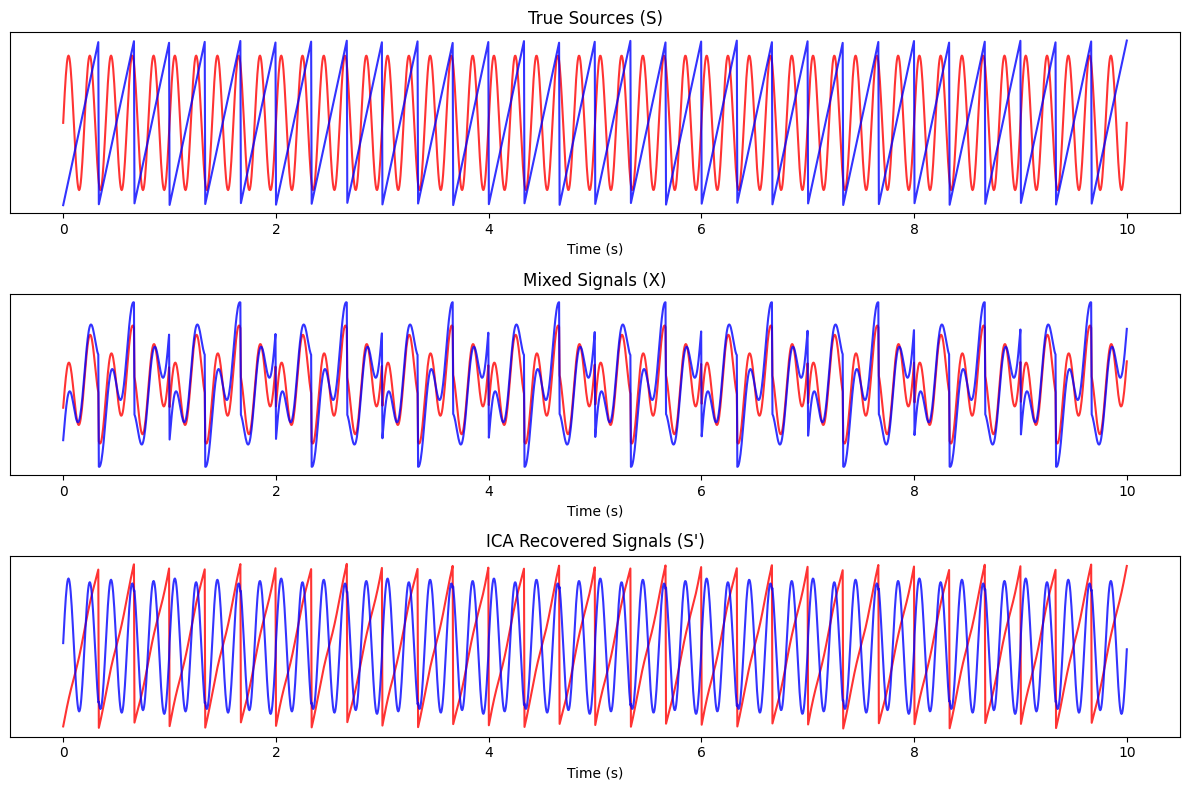

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp, sawtooth
from sklearn.decomposition import FastICA
from scipy.stats import pearsonr

# 1. Download 2 audio files (simulated as synthetic signals)
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 10, n_samples)

# Source 1: A sinusoidal signal (Speech/Music 1)
s1 = np.sin(2 * np.pi * 5 * time)
# Source 2: A sawtooth wave (Speech/Music 2)
s2 = sawtooth(2 * np.pi * 3 * time)

# Combine sources into a matrix (n_samples, n_sources)
S = np.c_[s1, s2]
S /= S.std(axis=0) # Standardize data

# 2. Create mixed signals by applying a random mixing matrix
# A (Mixing matrix) is a random 2x2 matrix
A = np.array([[1.0, 0.5], [0.8, 1.2]])

# X (Observations/Mixed signals) = S @ A.T
X = S @ A.T

# 3. Apply FastICA algorithm to separate original sources
ica = FastICA(n_components=2, random_state=0)
S_separated = ica.fit_transform(X) # Separated signals

# 4. Compare separated signals with original signals using correlation
# ICA can recover signals with flipped sign and different magnitude,
# so we check absolute correlation for matching
corr_s1_sep1 = pearsonr(S[:, 0], S_separated[:, 0])[0]
corr_s1_sep2 = pearsonr(S[:, 0], S_separated[:, 1])[0]
corr_s2_sep1 = pearsonr(S[:, 1], S_separated[:, 0])[0]
corr_s2_sep2 = pearsonr(S[:, 1], S_separated[:, 1])[0]

print("Correlation between True Sources (S) and Separated Signals (S'):")
print(f"Source 1 vs Separated 1: {abs(corr_s1_sep1):.4f}")
print(f"Source 1 vs Separated 2: {abs(corr_s1_sep2):.4f}")
print(f"Source 2 vs Separated 1: {abs(corr_s2_sep1):.4f}")
print(f"Source 2 vs Separated 2: {abs(corr_s2_sep2):.4f}")

# 5. Plot waveforms before and after ICA
plt.figure(figsize=(12, 8))
models = [S, X, S_separated]
names = ["True Sources (S)", "Mixed Signals (X)", "ICA Recovered Signals (S')"]
colors = ["red", "blue"]

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(3, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(time, sig, color=color, alpha=0.8)
    plt.xlabel('Time (s)')
    plt.yticks([]) # Hide y-axis for better visualization of waveforms

plt.tight_layout()
plt.show()